# Models using all variables

In [198]:
import pandas as pd

X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std_perf.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std_perf.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train_perf.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test_perf.csv")

Y values to array

In [199]:
from sklearn.preprocessing import StandardScaler

In [200]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [201]:
import numpy as np

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Lineal regression models

In [202]:
X_train_std = X_train_std.drop(["index", "ID_Zenodo"], axis=1)

X_test_std = X_test_std.drop(["index", "ID_Zenodo"], axis=1)

### Lineal Regression

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=5, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

In [204]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")

R2 train: 0.3194458686307047
R2 val: -2.4141273093944145e+24
R2 test: 0.2836956115627042


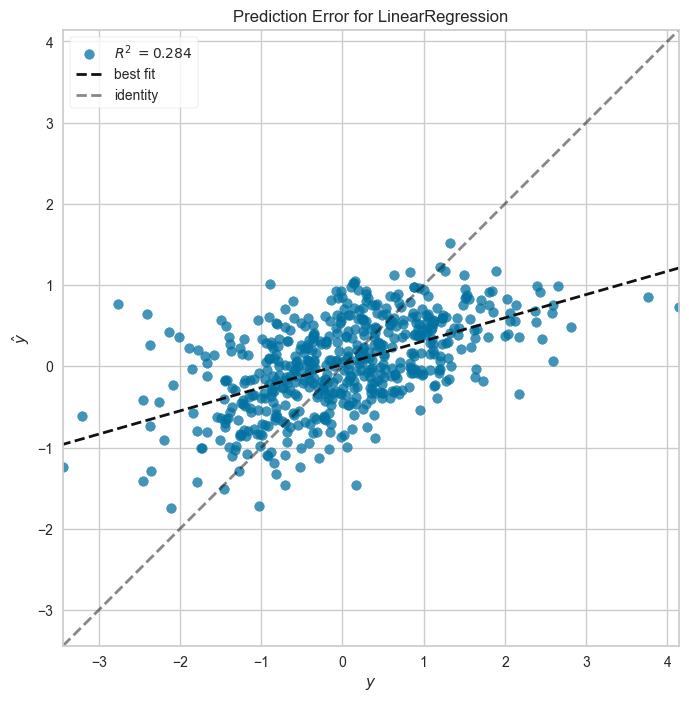

In [205]:
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

In [206]:
from sklearn.model_selection import cross_val_score
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alpha, scoring="r2", cv=5).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV(alphas=alpha, scoring="r2", cv=5), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Validation R2: ", ridge_r2_val2)

print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.3195546801915724
Validation R2:  0.28602355840429344
Validation R2:  0.28602355840429344
Test R2:  0.28221842430923516
100.0


### Lasso Regression

In [207]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, alphas=alpha).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(alphas=alpha, random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.3140405359905717
Validation R2:  0.28764372324489607
Test R2:  0.277967898362917
0.01


In [208]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train,}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results


[-2.4141273093944145e+24, 0.28602355840429344, 0.28764372324489607]


,LR,Ridge,Lasso
Train R2,3.194459e-01,0.319555,0.314041
CV (Val) R2,-2.414127e+24,0.286024,0.287644
Test R2,2.836956e-01,0.282218,0.277968
lambda,0.000000e+00,100.000000,0.010000


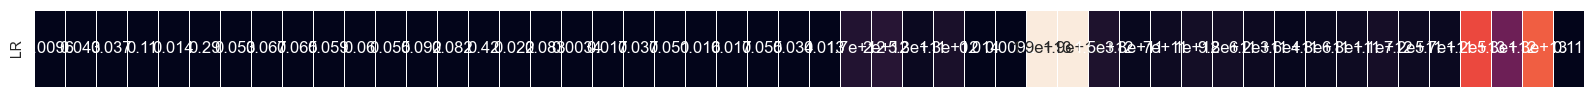

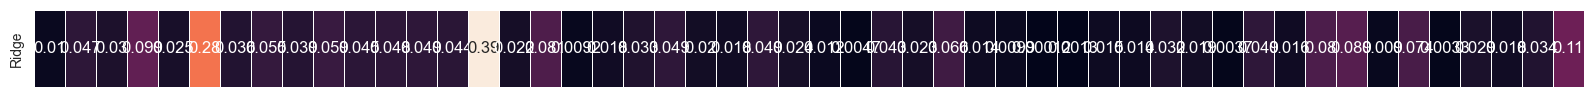

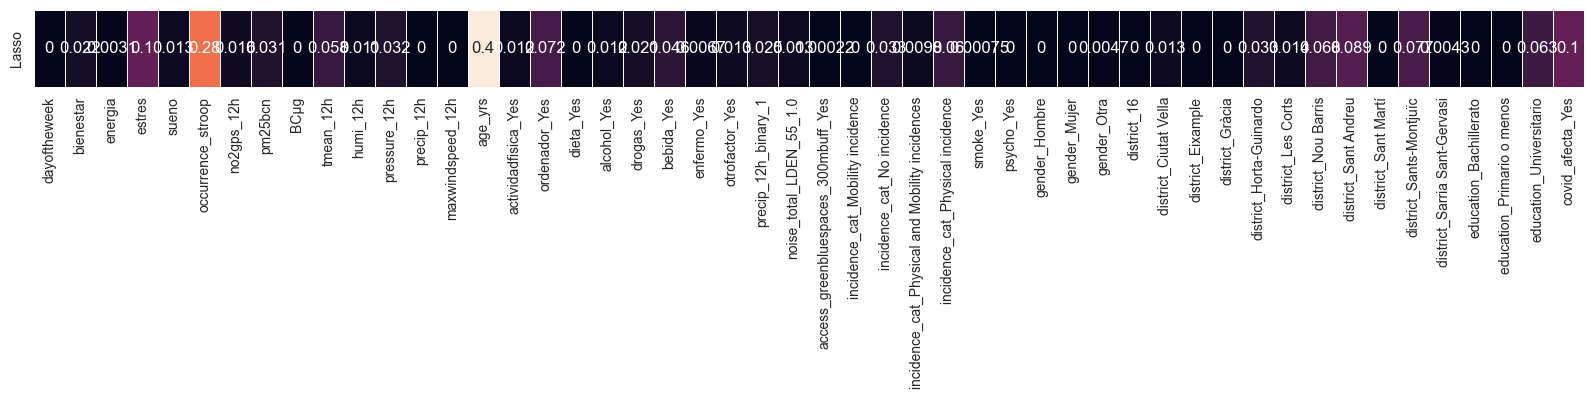

In [209]:

import matplotlib.pyplot as plt
import seaborn as sns

weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

# MLP (Multi Layer Perceptron)

In [210]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()


In [211]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from tensorflow.keras import regularizers

## First iteration

In [212]:

callback = EarlyStopping(monitor='loss',patience=3)

model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train_std.shape[1],)),
    Dense(1)
])
# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

# Train the model
num_epochs = 1000
batch_size = 32
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))



Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6486 - mean_squared_error: 1.6486 - val_loss: 0.8604 - val_mean_squared_error: 0.8604
Epoch 2/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8412 - mean_squared_error: 0.8412 - val_loss: 0.6931 - val_mean_squared_error: 0.6931
Epoch 3/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.7114 - mean_squared_error: 0.7114 - val_loss: 0.6331 - val_mean_squared_error: 0.6331
Epoch 4/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.6622 - mean_squared_error: 0.6622 - val_loss: 0.5991 - val_mean_squared_error: 0.5991
Epoch 5/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6131 - mean_squared_error: 0.6131 - val_loss: 0.5974 - val_mean_squared_error: 0.5974
Epoch 6/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.5729 - mean_squared_error: 0.5729 - val_loss: 0.5821 - val_mean_squared_error: 0.5821
Epoch 7/1000
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.5815 - mean_squared_error: 0.5815 - val_loss: 0.5677 - 

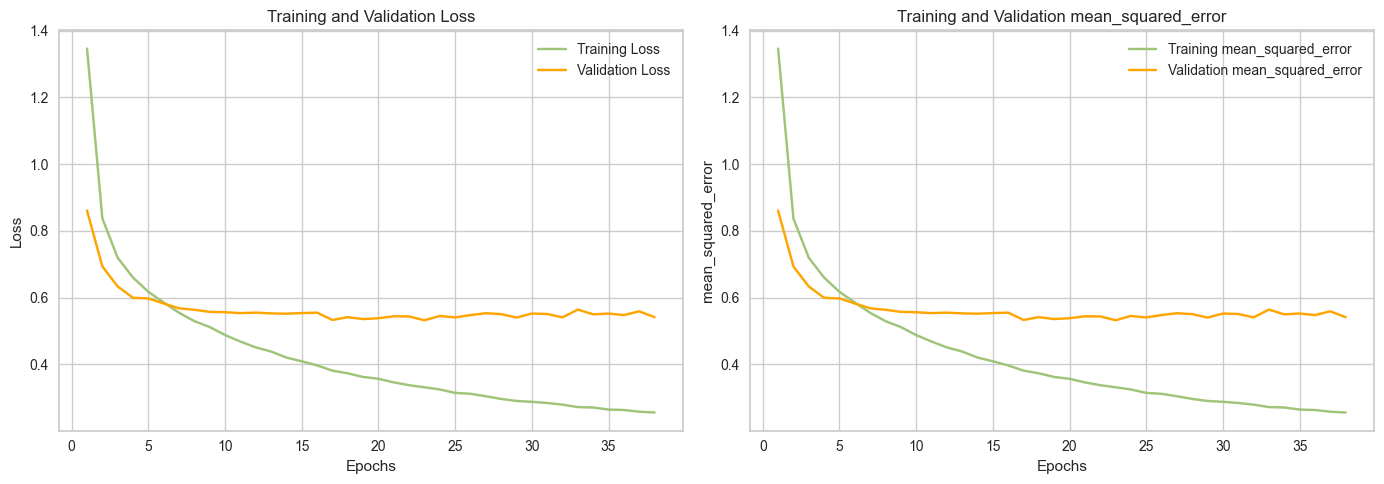

In [213]:
plot_curves(history)

## Second iteration

In [214]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.95
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=15)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7855 - mean_squared_error: 1.7855 - val_loss: 0.8237 - val_mean_squared_error: 0.8237
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9297 - mean_squared_error: 0.9297 - val_loss: 0.7994 - val_mean_squared_error: 0.7994
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8231 - mean_squared_error: 0.8231 - val_loss: 0.7606 - val_mean_squared_error: 0.7606
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7870 - mean_squared_error: 0.7870 - val_loss: 0.7339 - val_mean_squared_error: 0.7339
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7950 - mean_squared_error: 0.7950 - val_loss: 0.7085 - val_mean_squared_error: 0.7085
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7532 - mean_squared_error: 0.7532 - val_loss: 0.6821 - val_mean_squared_error: 0.6821
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6981 - mean_squared_error: 0.6981 - val_loss: 0.6557 - val_mean

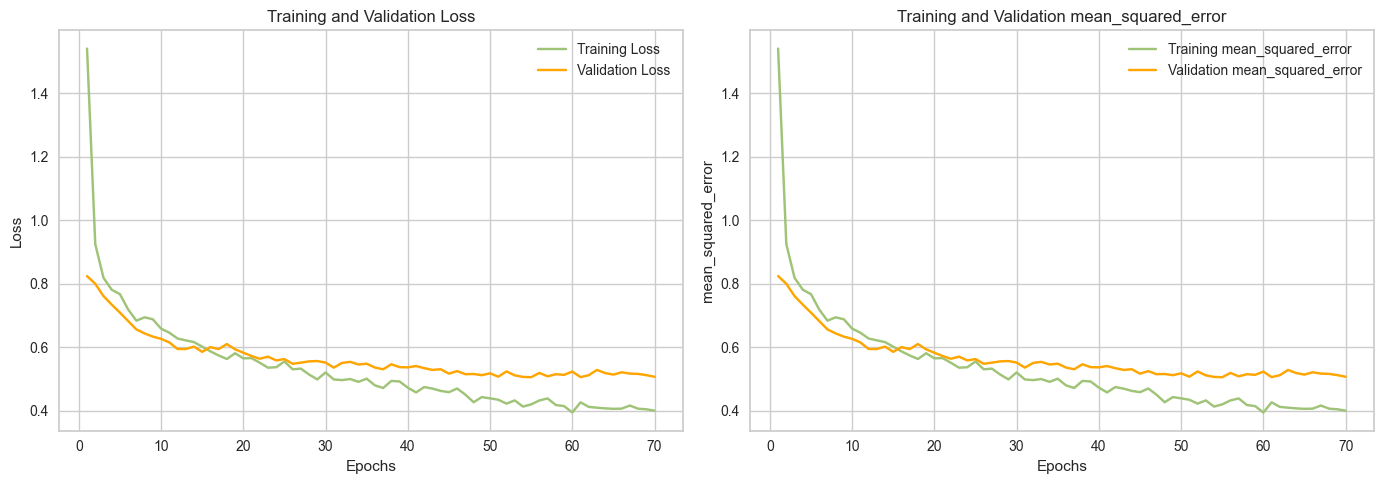

In [215]:
plot_curves(history)

## Third iteration

In [216]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.7),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.98
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=50)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7017 - mean_squared_error: 1.9602 - val_loss: 0.3886 - val_mean_squared_error: 0.9100
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4870 - mean_squared_error: 1.2343 - val_loss: 0.3596 - val_mean_squared_error: 0.8242
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4512 - mean_squared_error: 1.0854 - val_loss: 0.3594 - val_mean_squared_error: 0.8265
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3994 - mean_squared_error: 0.9450 - val_loss: 0.3547 - val_mean_squared_error: 0.8154
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3791 - mean_squared_error: 0.9077 - val_loss: 0.3471 - val_mean_squared_error: 0.7977
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3706 - mean_squared_error: 0.8853 - val_loss: 0.3249 - val_mean_squared_error: 0.7407
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3593 - mean_squared_error: 0.8257 - val_loss: 0.3062 - val_mean

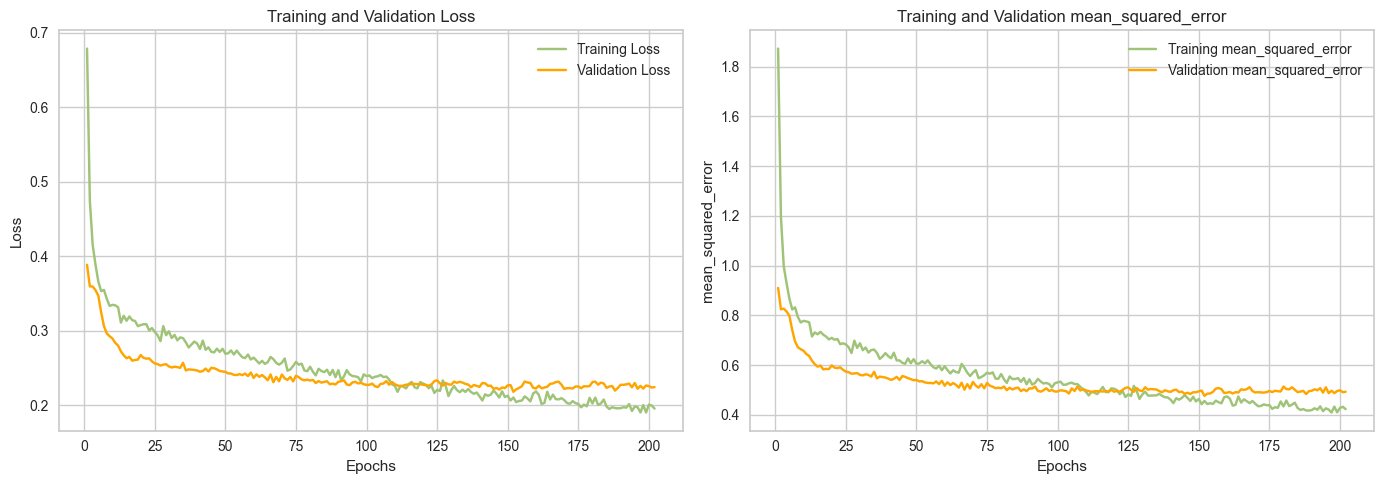

In [217]:
plot_curves(history)

## Fourth iteration

In [218]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.75),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.98
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=40)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


Epoch 1/1000


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8244 - mean_squared_error: 2.4826 - val_loss: 0.4432 - val_mean_squared_error: 1.0554
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6246 - mean_squared_error: 1.6873 - val_loss: 0.3937 - val_mean_squared_error: 0.9369
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4935 - mean_squared_error: 1.2831 - val_loss: 0.3763 - val_mean_squared_error: 0.8741
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4326 - mean_squared_error: 1.0429 - val_loss: 0.3841 - val_mean_squared_error: 0.9058
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3975 - mean_squared_error: 0.9640 - val_loss: 0.3589 - val_mean_squared_error: 0.8331
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3810 - mean_squared_error: 0.8923 - val_loss: 0.3629 - val_mean_squared_error: 0.8482
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4070 - mean_squared_error: 0.9840 - val_loss: 0.3388 - val_mean

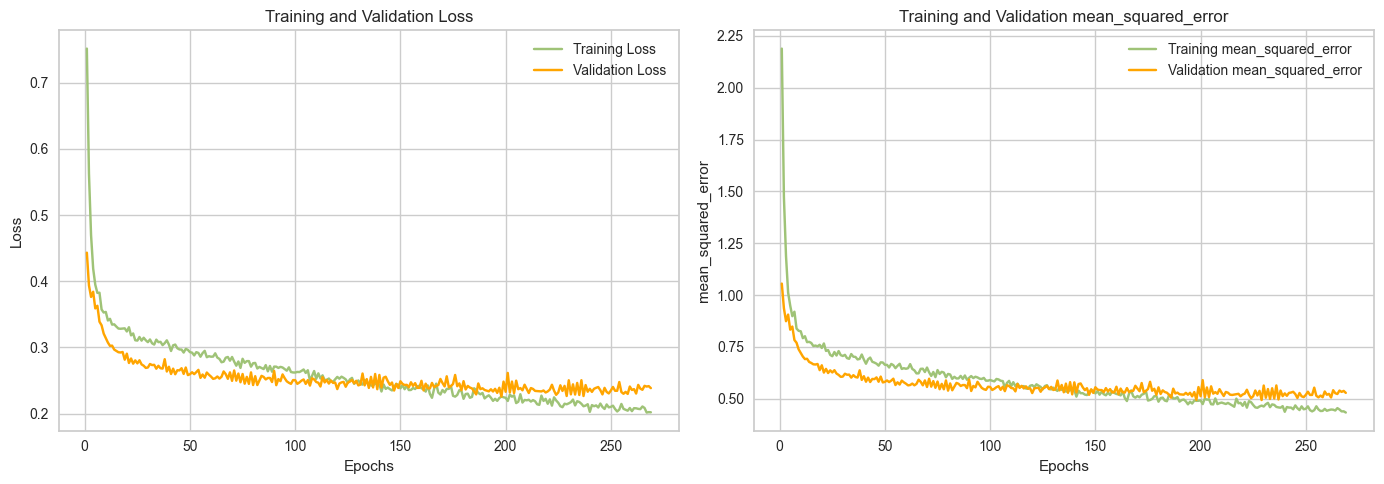

In [219]:
plot_curves(history)

### Utilitzant MLPRegressor

In [220]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(800, 800, 800, 400,), random_state=1, max_iter=500).fit(X_train_std, y_train)

regr.score(X_test_std, y_test)

0.49676197277818